1. Weights and average NTTs
2. A few keypoint distances increase with age. All have positive R2
	- All keypoint distances with age
	- Keypoint distances changes across age are consistent during particular behaviors
3. Avg joint angles during rearing / locomotion across age
	- All avg joint angles across age and behavior
4. Nonuniform scaling of head / torso, and change in ratio
5. Many nonuniform relationships (heat map and growth rates)
	- Consistent across behavior

### Setup

In [1]:
%load_ext autoreload
%autoreload --print 3

In [18]:
import jax.random as jr
jr.KeyArray = jr.PRNGKey
import shape_norm

from shape_norm.io import loaders
from shape_norm.models import joint
from shape_norm import config
from shape_norm.models import instantiation, setup, pose, morph, util as model_util
from shape_norm import fitting
from shape_norm.fitting import em
from shape_norm.io import alignment, features
from shape_norm.io.armature import Armature
from shape_norm.fitting import methods
from shape_norm.fitting import scans
from shape_norm.pca import fit_with_center, CenteredPCA, PCAData
from shape_norm.io.dataset import PytreeDataset
from shape_norm.io.dataset_refactor import Dataset, SessionMetadata
from shape_norm.models.morph.lowrank_affine import LRAParams, model as lra_model
from shape_norm.viz import styles

from blscale_loader import loader, linear_skeletal as blscale_ls

from collections import defaultdict
from shape_norm.viz import util as vu
from scipy import spatial
import itertools as iit
import numpy as np
import re
import jax
import jax.numpy as jnp
from pprint import pprint
from ruamel.yaml import YAML
import scipy.stats
from pathlib import Path
import matplotlib as mpl
import joblib as jl
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import itertools as iit
import pandas as pd
import seaborn as sns


In [152]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plot_dir = '/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.1_ikd-ja'
params_file = "/Users/kaifox/projects/mph/generative_api/test/notebooks/panels/plot_params.yml"

plot_meta = YAML(typ='safe').load(open(params_file, 'r'))
colors, plotter = styles.init_plt(plot_dir, style='default', fmt = 'pdf', **plot_meta['savefig'])
plt.rcParams.update(plot_meta['rc'])
plot_root = Path(plotter.plot_dir)

### supporting funcs


#### General supporting funcs

In [80]:
import jax.random as jr

jr.KeyArray = jr.PRNGKey
import numpy as np
import numpy.linalg as la
from scipy.signal import savgol_filter
import matplotlib.colors as mpl_col

# calculus and statistics
val_and_deriv = lambda x, w=5: (x, savgol_filter(x, w, polyorder=1, deriv=1, axis=0))
vel_acc = lambda x, w=5: val_and_deriv(  # x, shape (t, ..., spatial)
    la.norm(savgol_filter(x, w, polyorder=1, deriv=1, axis=0), axis=-1), w=w
)
cos = lambda a, b: np.clip(
    (a * b).sum(axis=-1) / (la.norm(a, axis=-1) * la.norm(b, axis=-1)), -1, 1
)
cov = lambda x, y: (x * y).mean(axis=-1) - x.mean(axis=-1) * y.mean(axis=-1)
corr = lambda a, b: cov(a, b) / np.sqrt(cov(a, a) * cov(b, b))
coef = lambda a, b: cov(a, b) / cov(a, a)
windowed_cov = lambda x, y, w: cov(
    *np.lib.stride_tricks.sliding_window_view(
        np.pad(
            np.stack([x, y]),
            ((0, 0), (int(np.ceil((w - 1) / 2)), int(np.floor((w - 1) / 2)))),
        ),
        window_shape=w,
        axis=1,
    )
)

# skeleton functions
bone_locations = lambda keypts, armature: np.stack(
    [
        keypts[..., armature.bones[i, 1], :] - keypts[..., armature.bones[i, 0], :]
        for i in range(len(armature.bones))
    ],
    axis=-2,
)
bone_lengths = lambda keypts, armature: la.norm(
    bone_locations(keypts, armature), axis=-1
)
elevation = (
    lambda arr: (
        np.arccos(cos(arr, arr * np.array([1, 1, 0])[None])) * np.sign(arr[:, 2])
    )
    * 180
    / np.pi
)
rotation = (
    lambda arr: (
        np.arccos(cos(arr, arr * np.array([1, 0, 1])[None])) * np.sign(arr[:, 1])
    )
    * 180
    / np.pi
)
short_bone_names = lambda armature: [
    armature.keypoint_names[int(i)] for i, j in armature.bones
]
long_bone_names = lambda armature: [
    f"{armature.keypoint_names[int(i)]}-{armature.keypoint_names[int(j)]}"
    for i, j in armature.bones
]


# model manipulation
def lra_anchor_poses(params, magnitudes=90):
    L = params.n_dims

    if isinstance(magnitudes, (int, float)):
        magnitudes = magnitudes * np.ones(L)

    # (n_bodies, n_dims, 1)
    anchors = (params.offset + params.offset_updates).reshape(params.n_bodies, -1, 1)
    # (n_bodies, n_dims, n_modes + 1)
    anchors = np.concatenate(
        [
            anchors,
            anchors + magnitudes[None, None] * (params.modes + params.mode_updates),
        ],
        axis=-1,
    )

    return anchors


def lra_induced_anchors(dataset, config, params, magnitudes, n_neighbors):
    from kpsn.models import util
    from kpsn.models.morph.lowrank_affine import model

    anchors = lra_anchor_poses(params, magnitudes)
    ref_data = dataset.get_session(dataset.ref_session)
    ref_anchor_diff = (
        ref_data[..., None]
        - anchors[None, dataset.session_body_id(dataset.ref_session)]
    )
    near_anchors_ix = np.array(
        [
            la.norm(ref_anchor_diff[..., j], axis=(-1)).argsort(axis=0)[:n_neighbors]
            for j in range(anchors.shape[-1])
        ]
    )
    induced_anchors = util.induced_reference_keypoints(
        dataset,
        config,
        model,
        params,
        include_reference=True,
        ref_frames=ref_data[near_anchors_ix].mean(axis=1),
    )

    return induced_anchors



### plotting


def plot_mouse_3d(
    frame,
    ax,
    armature,
    elev,
    rot,
    colors=None,
    bone_n=40,
    point_size=10,
    line_size=2,
    line_colors=None,
    point_kws={},
    line_kws={},
    boundary=True,
    set_aspect=True,
    label = None
):
    """all keys in point kws should be present in line kws"""

    if colors is None:
        import seaborn as sns

        colors = mpl_col.to_rgba(sns.color_palette("Blues", 10 + frame.shape[0])[10:])
    if line_colors is None:
        line_colors = colors
    colors = np.array([mpl_col.to_rgba(x) for x in colors])
    line_colors = np.array([mpl_col.to_rgba(x) for x in line_colors])
    point_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **point_kws,
    }
    line_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **line_kws,
    }

    # --- points

    x, y, z, c, s = [], [], [], [], []
    x.append(frame[:, 0])
    y.append(frame[:, 1])
    z.append(frame[:, 2])
    c.append(colors)
    s.append([point_size] * armature.n_kpts)
    kws = {k: [] for k in point_kws}
    concat_keys = []
    for k, v in point_kws.items():
        if np.array(v).shape[:1] == (armature.n_kpts,):
            concat_keys.append(k)
            kws[k].append(v)
        else:
            kws[k] = v

    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])
    point_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    # --- "lines"

    x, y, z, c, s = [], [], [], [], []
    kws = {k: [] for k in line_kws}
    concat_keys = []
    for i, (ch, pa) in enumerate(armature.bones):
        x.append(np.linspace(frame[ch, 0], frame[pa, 0], bone_n)[1:-1])
        y.append(np.linspace(frame[ch, 1], frame[pa, 1], bone_n)[1:-1])
        z.append(np.linspace(frame[ch, 2], frame[pa, 2], bone_n)[1:-1])
        c.append(np.full([bone_n - 2, 4], line_colors[ch]))
        s.append(np.full([bone_n - 2], line_size))
        for k, v in line_kws.items():
            if np.array(v).shape[:1] == (armature.n_kpts,):
                concat_keys.append(k)
                kws[k].append(np.full((bone_n - 2,) + np.array(v).shape[1:], v[ch]))
            else:
                kws[k] = v
    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])

    line_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    ax.view_init(elev, rot)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])
    if not boundary:
        ax.xaxis.pane.set_linewidth(0)
        ax.yaxis.pane.set_linewidth(0)
        ax.zaxis.pane.set_linewidth(0)
        ax.xaxis.line.set_linewidth(0)
        ax.yaxis.line.set_linewidth(0)
        ax.zaxis.line.set_linewidth(0)

    
    # use a.set_box_aspect to make the aspect equal to the ratio of the limits
    if set_aspect:
        xrng = np.ptp(ax.get_xlim())
        yrng = np.ptp(ax.get_ylim())
        zrng = np.ptp(ax.get_zlim())
        ax.set_box_aspect([xrng, yrng, zrng])

    return point_artist, line_artist

#### Raw keypoint data supporting funcs

In [81]:
def raw_data_armature_meta():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base', 't_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 't_base', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

def raw_data_armature_meta_no_tail():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

keypt_names = [
    'shldr',
    'back',
    'hips',
    't_base',
    'head',
    'l_ear',
    'r_ear',
    'nose',
    'lr_knee',
    'lr_foot',
    'rr_knee',
    'rr_foot',
    'lf_foot',
    'rf_foot'
]
keypt_ix = lambda k: keypt_names.index(k)
_names, _parents, _bones, _root = raw_data_armature_meta_no_tail()
arms = Armature(_names, _bones, _root, anterior=[], posterior=[])

# bone_names = [f'{keypt_names[i]}-{keypt_names[j]}' for i, j in armature.bones]
bone_names = [
    'hi back', #  'back-shldr',
    'lo back', #  'hips-back',
    'rump', #  't_base-hips',
    'neck', #  'head-shldr',
    'left ear', #  'l_ear-head',
    'right ear', #  'r_ear-head',
    'head', #  'nose-head',
    'left hindlimb', #  'lr_knee-hips',
    'left hind foot', #  'lr_foot-lr_knee',
    'right hindlimb', #  'rr_knee-hips',
    'right hind foot', #  'rr_foot-rr_knee',
    'left forelimb', #  'lf_foot-shldr',
    'right forelimb' #  'rf_foot-shldr'
]
keypt_parent = lambda ix, armature = arms: armature.bones[armature.bones[:, 0] == ix, 1][0]
has_parent = lambda ix, armature = arms: np.any(armature.bones[:, 0] == ix)
bone_ix = lambda keypt_ix, armature = arms: np.where(armature.bones[:, 0] == keypt_ix)[0][0]

joints = np.array([(child, parent, keypt_parent(parent)) for child, parent in arms.bones if has_parent(parent)])
joint_names = [f'{keypt_names[c]}-{keypt_names[p]}-{keypt_names[g]}' for c, p, g in joints]
joint_names = [
'back', #  'hips-back-shldr',
'hips', #  't_base-hips-back',
'left ear', #  'l_ear-head-shldr',
'right ear', #  'r_ear-head-shldr',
'head', #  'nose-head-shldr',
'left hindlimb', #  'lr_knee-hips-back',
'left hind foot', #  'lr_foot-lr_knee-hips',
'right hindlimb', #  'rr_knee-hips-back',
'right hind foot', #  'rr_foot-rr_knee-hips'
]

short_names = [keypt_names[i] for i, j in arms.bones]
full_joint_angles_func = (
    lambda kpts, joint_ix, joints: 180
    / np.pi
    * np.arccos(
        np.clip(
            cos(
                kpts[:, joints[joint_ix, 0], :] - kpts[:, joints[joint_ix, 1], :],
                kpts[:, joints[joint_ix, 2], :] - kpts[:, joints[joint_ix, 1], :],
            ),
            -1,
            1,
        )
    )
)
joint_angles = lambda kpts, joint_ix: full_joint_angles_func(kpts, joint_ix, joints)

#### Supervised ethogram supporting funcs

In [15]:
bhv_keys = {
    'rear': 'absolute_reer',
    'loco': 'locomotion',
    'raise': 'head_raise',
    'turn': 'bend',
    'hunch': 'hunch'
}
bhv_names = {
    'rear': "Rear",
    'loco': "Walk",
    'raise': "Head\nRaise",
    'turn': "Turn",
    'hunch': "Hunch",
}

#### Dataset functions

In [58]:
_with_match = lambda test, pattern, f: f(m) if (m := re.search(pattern, test)) else None
_name_func = lambda path, *a: _with_match(
    path, r"(?:/.*)+/\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy",
    lambda m: f"{m.group(1)}")

def full_ontogeny_data(data_dir, session_filter=None, ref_session=None):
    _sources = dict(map(lambda x: (_name_func(str(x)),) * 2, data_dir.glob(f"*.npy")))
    if session_filter is not None:
        _sources = {k: v for k, v in _sources.items() if session_filter(k)}
    ont_keypoints, _ = loader.from_sources_dict(
        data_dir,
        _sources,
        extension='.npy',
        name_func=_name_func,
    )
    names, parents, _, _ = raw_data_armature_meta()

    if ref_session is None:
        ref_session = list(ont_keypoints.keys())[0]

    project_config_kws = {
        "session_names": ont_keypoints.keys(),
        "bodies": {s: f'b-{s}' for s in ont_keypoints},
        "ref_session": ref_session,
        "keypoint_names": names,
        "keypoint_parents": parents,
    }

    return project_config_kws, ont_keypoints

def full_ontogeny_data_aligned(data_dir, session_filter=None, use_keypoints=None, scale_ntt=False):
    project_config_kws, ont_keypoints = full_ontogeny_data(data_dir, session_filter)
    if use_keypoints is None:
        use_keypoints = project_config_kws['keypoint_names']
    dataset = loaders.arrays.from_arrays(ont_keypoints, dict(
        type='arrays',
        subsample=None,
        subsample_to=None,
        ref_session=project_config_kws['ref_session'],
        sessions={s: dict(body=b) for s, b in project_config_kws['bodies'].items()},
        keypoint_names=project_config_kws['keypoint_names'],
        use_keypoints=use_keypoints,
        anterior=None,
        posterior=None,
        invert_axes=None,
    ))
    aligned, align_inv = alignment.align(dataset, dict(
        type='sagittal',
        origin='hips',
        anterior='head',
        rescale=scale_ntt,
        rescale_mode='session',
    ))
    return aligned, dataset, align_inv
    

#### Plotting funcs

In [156]:
def getc(spec):
    try:
        from cmap import Colormap, Color
        try:
            return Color(spec)
        except ValueError as e:
            stop = spec.split(':')[-1]
            if stop.startswith('.'):
                stop = float(stop)
            else:
                stop = int(stop)
            cm = Colormap(':'.join(spec.split(':')[:-1]))
            return cm(stop)
    except ImportError:
        return spec
    
plot_meta = YAML(typ='safe').load(open(params_file, 'r'))
age_pal = {k: getc(c) for k, c in plot_meta['colors']['age'].items()}
bhv_pal = {k: getc(c) for k, c in plot_meta['colors']['bhv'].items()}

plotdrop_kws = lambda c, ps, ls: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * arms.n_kpts) if np.array(c).ndim < 2 else c,
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(x[..., 2].min() + z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(x[..., 1].max() + y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(x[..., 0].min() + xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, lsm=1, shad=True, dropax=None, shad_x = True, shad_y=True, shad_z=True, **kws: [
    plot_mouse_3d(f, a, **{**plotdrop_kws(c, sm * 15, 1.5 * lsm), **kws})
    ] + [
    dropax := dropax if dropax is not None else a,
    ] + ([
    plot_mouse_3d(dropz(f, -7), dropax, **plotdrop_kws('.9', sm * 7, 1 * lsm)) if shad_z else None,
    plot_mouse_3d(dropy(f, 10), dropax, **plotdrop_kws('.9', sm * 7, 1 * lsm)) if shad_y else None,
    plot_mouse_3d(dropx(f, -7), dropax, **plotdrop_kws('.9', sm * 7, 1 * lsm)) if shad_x else None,
] if shad else [])

### load data

In [59]:
data_dir = "/Users/kaifox/projects/mph/data_explore/data"
ont_dataset, unaligned_dataset, align_inv = full_ontogeny_data_aligned(
    Path(data_dir),
    session_filter = lambda s: re.search(r"(\d+)wk", s).group(1) not in ['9', '12'],
    use_keypoints=[
        'shldr', 'back', 'hips', 't_base', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'])
obs_keypts = {s: ont_dataset.get_session(s) for s in ont_dataset.sessions}
unaligned = {s: unaligned_dataset.get_session(s) for s in unaligned_dataset.sessions}
sessions = ont_dataset.sessions
src_sess = "24wk_m0"
src_keypts = obs_keypts[src_sess]

# sessions = metadata['session_slice'].keys()
# slices = metadata['session_slice']
# src_sess = '24wk_m0'
# obs_keypts = {s: gt_obs.keypts[slices[s]].reshape([-1, 14, 3]) for s in sessions}
# unaligned = {s: inverse_saggital_align(obs_keypts[s], metadata['centroid'][s], metadata['rotation'][s]) for s in sessions}
# src_kpts = obs_keypts[src_sess]

age_groups = defaultdict(list)
for s in sessions:
    age_groups[s.split('_')[0].rstrip('wk')].append(s)
age_groups = dict(age_groups)
ages = sorted(list(age_groups.keys()), key = lambda x: int(x))

print("Age groups:")
pprint(age_groups)

Loading keypoints: 100%|███████████████| 36/36 [00:00<00:00, 267.54it/s]


Age groups:
{'24': ['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '24wk_m4', '24wk_m5'],
 '3': ['3wk_m1', '3wk_m0', '3wk_m2', '3wk_m3'],
 '5': ['5wk_m6',
       '5wk_m7',
       '5wk_m5',
       '5wk_m4',
       '5wk_m0',
       '5wk_m1',
       '5wk_m3',
       '5wk_m2'],
 '52': ['52wk_m0', '52wk_m1', '52wk_m3', '52wk_m2', '52wk_m5', '52wk_m4'],
 '7': ['7wk_m3', '7wk_m2', '7wk_m0', '7wk_m1'],
 '72': ['72wk_m2',
        '72wk_m3',
        '72wk_m1',
        '72wk_m0',
        '72wk_m4',
        '72wk_m5',
        '72wk_m7',
        '72wk_m6']}


In [60]:
bhv_labels = jl.load('/Users/kaifox/projects/mph/data_explore/data/moont_scalar-classifier-behaviors.p')
bhv_masks = {k: bhv_labels['masks'][n] for k, n in bhv_keys.items()}
rear_mask = bhv_labels['masks']['absolute_reer']
loco_mask = bhv_labels['masks']['locomotion']

### 1. Average weight and NTT with age

In [61]:
# load subject weight metadata
subj_meta = pd.read_csv('/Users/kaifox/projects/mph/data_explore/data/meta.csv')

In [62]:
subj_meta.head()

,Age (wk),Subject #,Sex,Weight (g),Date
0,3,0,Female,14.4,10/11/2022
1,3,1,Female,15.2,10/11/2022
2,3,2,Female,14.2,10/11/2022
3,3,3,Female,13.3,10/11/2022
4,72,0,Female,30.5,10/14/2022


Weight increase across dataset: 14.274999999999999 32.45
Weight increase across dataset: [13.575 14.95 ] [30.575     34.2765625]
NTT increase across dataset: 58.55309304442557 75.70634218471902
Weight increase across dataset: [55.73688687 60.39113011] [72.97436268 78.24128471]


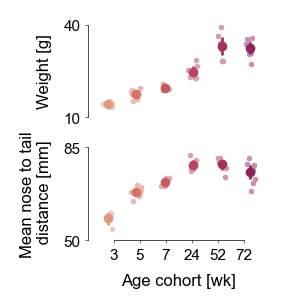

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.1_ikd-ja/weight-ntt-age.pdf')

In [68]:
age_groupby = subj_meta.groupby('Age (wk)')
wt = [age_groupby.get_group(int(a))['Weight (g)'].values for a in ages]
print("Weight increase across dataset:", wt[0].mean(), wt[-1].mean())
print("Weight increase across dataset:", vu.ci(wt[0], n = 1000, absolute=True), vu.ci(wt[-1], n = 1000, absolute=True))

ntt_dist = lambda kpts: (
    la.norm(kpts[:, keypt_ix('nose'), :] - kpts[:, keypt_ix('t_base'), :], axis = -1)
)
ntt = [np.array([ntt_dist(obs_keypts[s]).mean() for s in age_groups[a]]) for a in ages]
print("NTT increase across dataset:", ntt[0].mean(), ntt[-1].mean())
print("Weight increase across dataset:", vu.ci(ntt[0], n = 1000, absolute=True), vu.ci(ntt[-1], n = 1000, absolute=True))


kw = dict(
    error = lambda a, **kw: vu.ci(a, level=0.95, n=1000),
    errorbar_kw = {'elinewidth': 1, 'ms': 2.5},
    points_kw=dict(ms=1),
    jitter = 0.2,
    lighten_points = 0.5,
    lim_buffer = 1,
    colors = age_pal
    # colors = "k"
)

fig, ax = plt.subplots(2, 1, figsize = (1.4, 1.5), dpi=100)
vu.grouped_stripplot(vu.expand_groups(wt, ages), ax = ax[0], xticks = "", **kw)
ax[0].set_ylabel('Weight [g]')
vu.nticks(ax, 2, x = False)
ax[0].set_ylim(10, 40)
ax[0].set_xticks([])
sns.despine(ax = ax[0], bottom = True)

vu.grouped_stripplot(vu.expand_groups(ntt, ages), ax = ax[1], xticks = ages, **kw)
ax[1].set_ylabel('Mean nose to tail\n distance [mm]')
ax[1].set_xlabel('Age cohort [wk]')
vu.nticks(ax, 2, x = False)
ax[1].set_ylim(50, 85)
sns.despine(ax = ax[1], trim = True)

plotter.finalize(fig, "weight-ntt-age", despine=False)

### 2. A few keypoint distances increase with age. All have positive R2

Supplementary:
- 2.1 All keypoint distances with age
- 2.2 Keypoint distances changes across age are consistent during particular behaviors

In [7]:
bls = {s: la.norm(bone_locations(obs_keypts[s], skeleton.default_armature), axis = -1) for s in sessions}
mean_fl = {s: (bls[s][:, bone_names.index('left forelimb')] + bls[s][:, bone_names.index('left forelimb')]) / 2 for s in sessions}
head = {s: bls[s][:, bone_names.index('head')] for s in sessions}
lo_back = {s: bls[s][:, bone_names.index('lo back')] for s in sessions}

../../plots/notebook/panels/v4/f1.1_ikd-ja/example_ikds_v_age.pdf


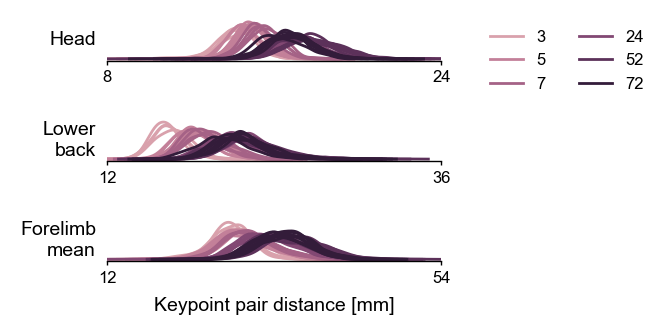

In [52]:
kw = dict(
    error = lambda a, **kw: viz.util.ci(a, level=0.95, n=1000),
    errorbar_kw = {'elinewidth': 0.5, 'ms': 2},
    jitter = 0.2,
    lighten_points = 0.5,
    lim_buffer = 1,
    colors = "k"
)

fig, ax = plt.subplots(3, 1, figsize = (3.5, 1.7))
for a in ages:
    for s in age_groups[a]:
        
        ax[0].plot(*viz.util.kde(head[s][::100], bw = 0.3, resolution = 300), lw = 1, color = colors.age_pal[a],
            label = a)
        ax[1].plot(*viz.util.kde(lo_back[s][::100], bw = 0.5, resolution = 300), lw = 1, color = colors.age_pal[a])
        ax[2].plot(*viz.util.kde(mean_fl[s][::100], bw = 1, resolution = 300), lw = 1, color = colors.age_pal[a])

viz.util.nticks(ax, 2)
for a in ax:
    a.set_yticks([])
    mean_lim = np.mean(a.get_xlim())
    limrng = np.ptp(a.get_xlim())
    viz.util.round_limits(a, precision = 0.8, y = False, vmin = mean_lim - 0.35 * limrng, vmax = mean_lim + 0.35 * limrng)
    sns.despine(ax = a, trim = True, left = True)

ax[0].set_ylabel('Head', rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
ax[1].set_ylabel('Lower\nback', rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
ax[2].set_ylabel('Forelimb\nmean', rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
ax[2].set_xlabel('Keypoint pair distance [mm]')

viz.util.legend(ax[0], viz.util.unique_handles(ax[0]), ncols = 2, bbox_to_anchor = (1.1, 0))


plotter.finalize(fig, "example_ikds_v_age", save=True, despine=False, transparent = True)

In [29]:
r2s = []
mean_r2s = []
for i in range(len(bone_names)):
    x = np.concatenate([
        np.full(len(bls[s]), ages.index(a))
        for a, sl in age_groups.items() for s in sl
    ])
    y = np.concatenate([bls[s][:, i] for a, sl in age_groups.items() for s in sl])
    r2s.append(scipy.stats.pearsonr(x, y).statistic)
    
    x = np.array([np.log(int(a)) for a, sl in age_groups.items() for s in sl])
    y = np.array([np.mean(bls[s][:, i]) for a, sl in age_groups.items() for s in sl])
    mean_r2s.append(np.sqrt(scipy.stats.pearsonr(x, y).statistic))

../../plots/notebook/panels/v4/f1.1_ikd-ja/mean_ikd_age_correlation.pdf


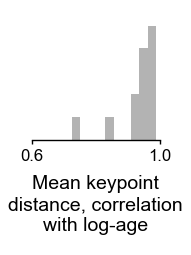

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (1, 1.3))
ax.hist(mean_r2s, bins = 10, color = colors.semisubtle)
viz.util.nticks(ax, 2)
viz.util.round_limits(ax, precision = 0.2, fixed_vmax = 1, y = False)
ax.set_yticks([])
ax.set_xlabel("Mean keypoint\ndistance, correlation\nwith log-age")
sns.despine(ax = ax, trim = True, left = True)
plotter.finalize(fig, "mean_ikd_age_correlation", save=True, despine=False, transparent = True)

### 4. Nonuniform scaling of head / torso

../../plots/notebook/panels/v4/f1.1_ikd-ja/torso-head-rto.pdf


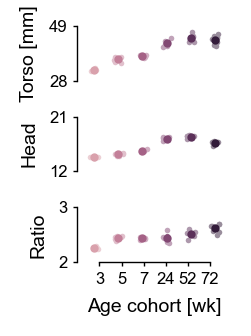

In [14]:
torso_length = lambda kpts: (
    la.norm(kpts[:, keypt_ix('shldr'), :] - kpts[:, keypt_ix('back'), :], axis = -1) +
    la.norm(kpts[:, keypt_ix('back'), :] - kpts[:, keypt_ix('hips'), :], axis = -1)
)
head_length = lambda kpts: la.norm(kpts[:, keypt_ix('nose'), :] - kpts[:, keypt_ix('head'), :], axis = -1)
tl = [np.array([torso_length(obs_keypts[s]).mean() for s in age_groups[a]]) for a in ages]
hl = [np.array([head_length(obs_keypts[s]).mean() for s in age_groups[a]]) for a in ages]
rto = [np.array([(torso_length(obs_keypts[s]) / head_length(obs_keypts[s])).mean() for s in age_groups[a]]) for a in ages]


tl_samp = [viz.util.ci(l, n = 1000, return_samples=True) for l in [tl[0], tl[-1]]]
hl_samp = [viz.util.ci(l, n = 1000, return_samples=True) for l in [hl[0], hl[-1]]]

kw = dict(
    error = lambda a, **kw: viz.util.ci(a, level=0.95, n=1000),
    jitter = 0.2,
    lighten_points = 0.5,
    lim_buffer = 1,
    colors = colors.age_pal,
)
fig = plt.figure(figsize = (1.3, 1.7))
ax = fig.add_subplot(311)
viz.util.grouped_stripplot(viz.util.expand_groups(tl, ages), ax = ax, xticks = "", **kw)
ax.set_ylabel('Torso [mm]')
viz.util.nticks(ax, 2, x = False)
viz.util.round_limits(ax, x = False, precision=0.4)
ax.set_xticks([])
sns.despine(ax = ax, bottom = True)

ax = fig.add_subplot(312)
ax.set_ylabel('Head')
viz.util.grouped_stripplot(viz.util.expand_groups(hl, ages), ax = ax, xticks = "", **kw)
ax.set_ylim(13, 20)
viz.util.nticks(ax, 2, x = False)
viz.util.round_limits(ax, x = False, precision=0.4)
ax.set_xticks([])
sns.despine(ax = ax, bottom = True)


ax = fig.add_subplot(313)
viz.util.grouped_stripplot(viz.util.expand_groups(rto, ages), ax = ax, xticks = ages, **kw)
ax.set_ylabel('Ratio')
ax.set_xlabel('Age cohort [wk]')
ax.set_ylim(2, 3)
viz.util.nticks(ax, 2, x = False)
sns.despine(ax = ax, trim = True)

plotter.finalize(fig, "torso-head-rto", save=True, despine=False, transparent = True)

In [19]:
x = np.round(tl[-1].mean() / tl[0].mean(), 2)
ci = np.round(np.quantile(tl_samp[1] / tl_samp[0], [0.025, 0.975]), 2)
print("Torso length factor:", f"{x} ([{ci[0]}, {ci[1]}])")

x = np.round(hl[-1].mean() / hl[0].mean(), 2)
ci = np.round(np.quantile(hl_samp[1] / hl_samp[0], [0.025, 0.975]), 2)
print("Head length factor:", f"{x} ([{ci[0]}, {ci[1]}])")

Torso length factor: 1.36 ([1.32, 1.4])
Head length factor: 1.17 ([1.16, 1.18])


In [129]:

frames_bl_bhv = {
    k: [
        [la.norm(bone_locations(obs_keypts[s][bhv_labels['masks'][mask_name][s]], arms), axis = -1)
            for s in age_groups[a]]
        for a in ages
    ]
    for k, mask_name in bhv_keys.items()
}
all_bl_bhv = {
    k: [np.array([arr.mean(axis = 0) for arr in l]) for l in frames_bl_bhv[k]]
    for k in bhv_keys
}

frames_bl_total = [
    [la.norm(bone_locations(obs_keypts[s], arms), axis = -1)
        for s in age_groups[a]]
    for a in ages
]
all_bl_total = [np.array([arr.mean(axis = 0) for arr in l]) for l in frames_bl_total]

#### 1.1: all bone lengths vs age

In [ ]:
ex_sess = '24wk_m0'
ex_frame = 0

fig, ax = plt.figure(len(bone_names), 3, figsize = ((1.5 + 1.3 + 1), 0.5 * len(bone_names)), width_ratios=[.75, .75, 1.3])
for i, n in enumerate(bone_names):
    is_bottom = i == len(bone_names) - 1
    viz.util.grouped_stripplot(
        {"rearing": [arr[:, i] for arr in all_bl_rear],
         "locomotion": [arr[:, i] for arr in all_bl_loco]},
        ax = ax[i, 2],
        xticks = ages if is_bottom else "",
        **{**kw, **{'colors': {'rearing': colors.rear, 'locomotion': colors.loco}}},
        offset=False,
        labels = True if i == 0 else None
    )

    viz.util.nticks(ax[i, 2], 2, x = False)
    viz.util.round_limits(ax[i, 2], x = False, precision=1, pad = 0.3)
    if is_bottom:
        ax[i, 2].set_xlabel('Age cohort [wk]')


    if is_bottom:
        sns.despine(ax = ax[i, 2], trim = True)
    else:
        ax[i, 2].set_xticks([])
        sns.despine(ax = ax[i, 2], bottom = True)


    viz.util.plot_mouse_views(
        ax[i, :2],
        obs_keypts[ex_sess][ex_frame],
        skeleton.default_armature,
        color = colors.semisubtle,
        line_kw = [
            {'lw': 1., 'color': 'C3', 'solid_capstyle':'butt'} if j == i else {'lw': 0.5}
            for j in range(len(bone_names))
        ],
        scatter_kw = {'s': 0.3}
    )
    viz.util.axes_off(ax[i, :2])

for i in range(0, len(short_names)):
    ax[i, 0].set_ylabel(short_names[i])
ax[1, 0].set_ylabel("end keypoint\n" + short_names[1])
plotter.finalize(fig, 'all-bl-age-bhv', despine=False, transparent = True)

0 hi back False
1 lo back False
2 rump False
3 neck False
4 left ear False
5 right ear False
6 head False
7 left hindlimb False
8 left hind foot False
9 right hindlimb False
10 right hind foot False
11 left forelimb False
12 right forelimb True


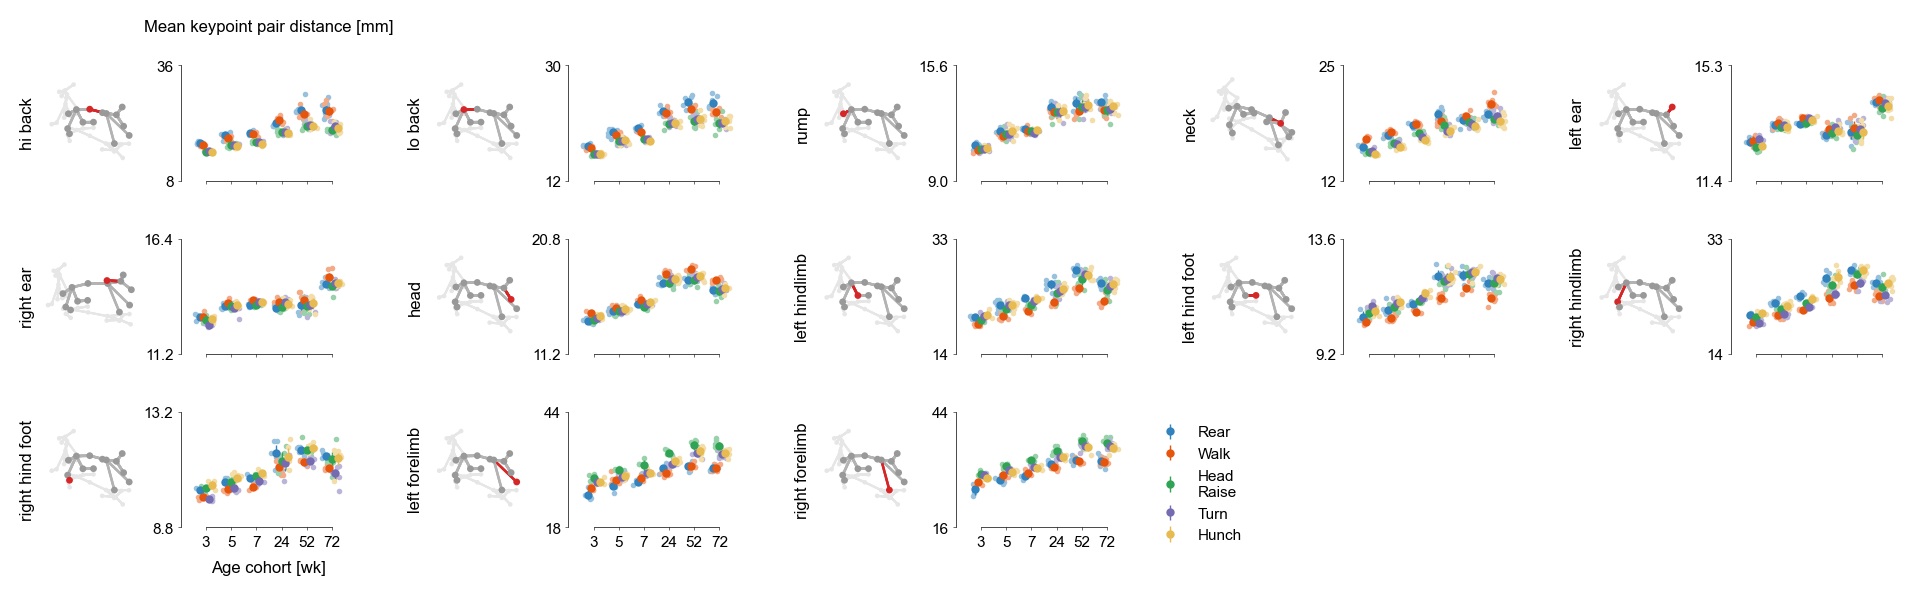

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.1_ikd-ja/all-bl-age-bhv.pdf')

In [161]:
ex_sess = '24wk_m0'
ex_frame = 0
ncol = 5
nrow = int(np.ceil(len(bone_names) / ncol))

kw = dict(
    error = lambda a, **kw: vu.ci(a, level=0.95, n=1000),
    jitter = 0.2,
    lighten_points = 0.5,
    lim_buffer = 1,
    points_kw = {'ms': 1},
    errorbar_kw = {'elinewidth': 0.5, 'ms': 2},
)

fig = plt.figure(figsize = ((1 + 1 + 0.5) * ncol, 1 * nrow))
gs = plt.GridSpec(nrow, ncol * 3, wspace=0, hspace=0.5, width_ratios=[1, 1, 0.2] * ncol)
row_ix, col_ix = zip(*[(i // ncol, i % ncol) for i in range(len(bone_names))])
ex_ax = [fig.add_subplot(gs[row_ix[i], 3 * col_ix[i]], projection='3d') for i in range(len(bone_names))]
len_ax = [fig.add_subplot(gs[row_ix[i], 3 * col_ix[i] + 1]) for i in range(len(bone_names))]
for i, n in enumerate(bone_names):
    pt_clr = [mpl_col.to_rgba('.6')] * arms.n_kpts
    pt_clr[arms.bones[i, 0]] = mpl_col.to_rgba('C3')
    ln_clr = [mpl_col.to_rgba('.7')] * arms.n_kpts
    ln_clr[arms.bones[i, 0]] = mpl_col.to_rgba('C3')
    
    plotdrop(
        obs_keypts[ex_sess][ex_frame], ex_ax[i], 
        pt_clr
        , 0.4, 0.6,
        shad_y=False,
        line_colors = ln_clr
        
    )
    ex_ax[i].view_init(30, -45)
    ex_ax[i].text2D(0, 0.5, n, rotation=90, ha = 'right', va = 'center', transform=ex_ax[i].transAxes)
    if n == 'neck':
        ex_ax[i].view_init(50, -50)
    if n == 'right ear':
        ex_ax[i].view_init(20, -60)
    

    is_bottom = row_ix[i] == nrow - 1
    is_rightmost = col_ix[i] == ncol - 1
    is_top = row_ix[i] == 0
    is_leftmost = col_ix[i] == 0
    is_last = i == len(bone_names) - 1
    vu.grouped_stripplot(
        {bhv_names[k]: [arr[:, i] for arr in all_bl_bhv[k]] for k in bhv_keys},
        ax = len_ax[i],
        xticks = ages if is_bottom else "",
        **{**kw, **{'colors': {bhv_names[k]: bhv_pal[k] for k in bhv_keys}}},
        offset=True,
        labels = True if is_last else None
    )

    vu.nticks(len_ax[i], 2, x = False)
    vu.round_limits(len_ax[i], x = False, precision=1, pad = 0.3)
    if is_bottom and is_leftmost:
        len_ax[i].set_xlabel('Age cohort [wk]')
    if is_top and is_leftmost:
        len_ax[i].set_title("Mean keypoint pair distance [mm]\n")
    
    sns.despine(ax = len_ax[i], trim = True)
    

plotter.finalize(fig, 'all-bl-age-bhv', tight=False)

### 3: joint angles during rearing / locomotion across age

Supplements
- (2.1) All joint angles during rearing / lomomotion

In [75]:
all_ja_rear = [
    np.array([[joint_angles(obs_keypts[s][rear_mask[s]], j).mean() for j in range(len(joints))]
        for s in age_groups[a]])
    for a in ages
]
all_ja_loco = [
    np.array([[joint_angles(obs_keypts[s][loco_mask[s]], j).mean() for j in range(len(joints))]
        for s in age_groups[a]])
    for a in ages
]

NameError: name 'rear_mask' is not defined

../../plots/notebook/panels/v4/f1.1_ikd-ja/example-ja-bhv.pdf


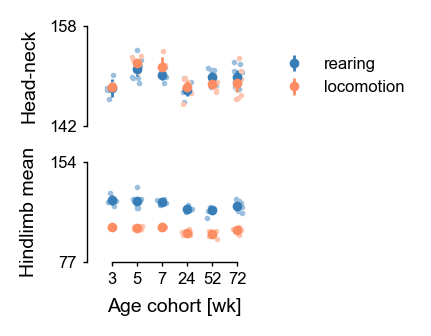

In [126]:
head_ix = joint_names.index('head')
lh_ix = joint_names.index('left hindlimb')
rh_ix = joint_names.index('right hindlimb')

kws = dict(
    **{**kw, **{'colors': {'rearing': colors.rear, 'locomotion': colors.loco}}},
    offset=False,
    labels = True,
    legend = False
)

fig, ax = plt.subplots(2, 1, figsize = (2.2, 1.7))

viz.util.grouped_stripplot(
    {"rearing": [arr[:, head_ix] for arr in all_ja_rear],
    "locomotion": [arr[:, head_ix] for arr in all_ja_loco]},
    ax = ax[0],
    xticks = "",
    **kws,
)
viz.util.grouped_stripplot(
    {"rearing": [(arr[:, lh_ix] + arr[:, rh_ix]) / 2 for arr in all_ja_rear],
    "locomotion": [(arr[:, lh_ix] + arr[:, rh_ix]) / 2 for arr in all_ja_loco]},
    ax = ax[1],
    xticks = ages,
    **kws,
)

for a in ax:
    viz.util.nticks(a, 2, x = False)
    viz.util.round_limits(a, x = False, precision=1, pad = 0.3)
ax[0].set_xticks([])
sns.despine(ax = ax[0], bottom = True)
sns.despine(ax = ax[1], trim = True)
ax[0].set_ylabel('Head-neck')
ax[1].set_ylabel('Hindlimb mean')
    
ax[1].set_xlabel('Age cohort [wk]')
viz.util.legend(ax[0])

plotter.finalize(fig, 'example-ja-bhv', save = True, despine=False, transparent = True)

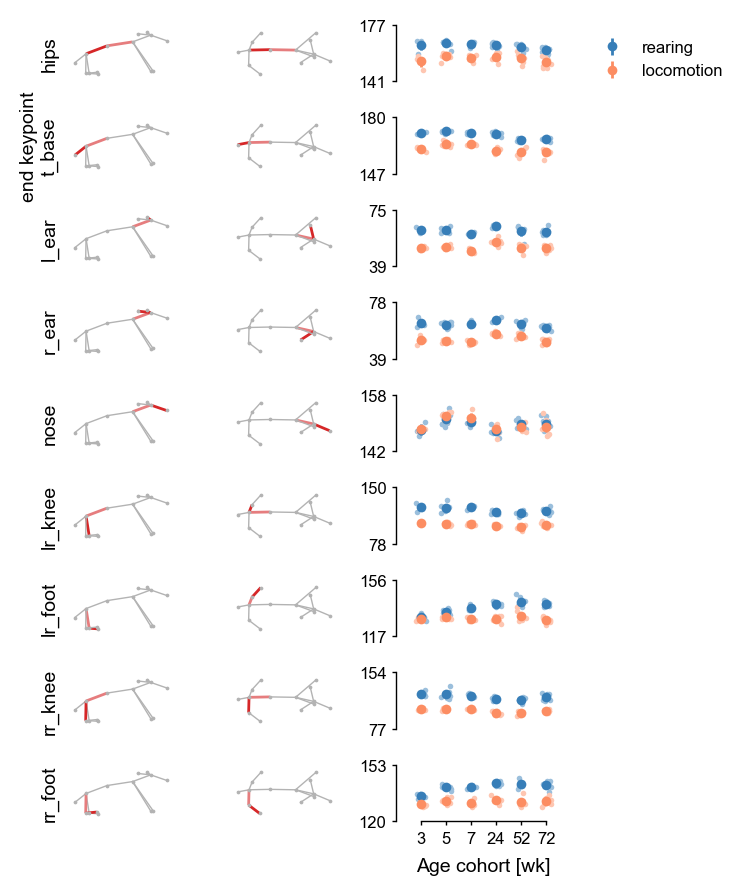

In [104]:
ex_sess = '24wk_m0'
ex_frame = 0

fig, ax = plt.subplots(len(joint_names), 3, figsize = ((1.5 + 1.3 + 1), 0.5 * len(joint_names)), width_ratios=[0.75, 0.75, 1.3])
for i, n in enumerate(joint_names):
    is_bottom = i == len(joint_names) - 1
    viz.util.grouped_stripplot(
        {"rearing": [arr[:, i] for arr in all_ja_rear],
         "locomotion": [arr[:, i] for arr in all_ja_loco]},
        ax = ax[i, 2],
        xticks = ages if is_bottom else "",
        **{**kw, **{'colors': {'rearing': colors.rear, 'locomotion': colors.loco}}},
        offset=False,
        labels = True if i == 0 else None
    )

    viz.util.nticks(ax[i, 2], 2, x = False)
    viz.util.round_limits(ax[i, 2], x = False, precision=1, pad = 0.3)
    if is_bottom:
        ax[i, 2].set_xlabel('Age cohort [wk]')


    if is_bottom:
        sns.despine(ax = ax[i, 2], trim = True)
    else:
        ax[i, 2].set_xticks([])
        sns.despine(ax = ax[i, 2], bottom = True)

    ch, pa, ga = joints[i]
    ch = np.where(skeleton.default_armature.bones[:, 0] == ch)[0]
    pa = np.where(skeleton.default_armature.bones[:, 0] == pa)[0]
    viz.util.plot_mouse_views(
        ax[i, :2],
        obs_keypts[ex_sess][ex_frame],
        skeleton.default_armature,
        color = colors.semisubtle,
        line_kw = [
            {'lw': 1., 'color': 'C3', 'solid_capstyle':'butt'} if j == ch
            else ({'lw': 1., 'color': viz.util.lighten('C3', 0.4), 'solid_capstyle':'butt'} if j == pa
            else {'lw': 0.5})
            for j in range(len(bone_names))
        ],
        scatter_kw = {'s': 0.3}
    )
    viz.util.axes_off(ax[i, :2])

for i in range(0, len(joint_names)):
    ax[i, 0].set_ylabel(joint_names[i].split('-')[0])
ax[1, 0].set_ylabel("end keypoint\n" + joint_names[1].split('-')[0])

plotter.finalize(fig, 'all-ja-age-bhv', save = False, despine=False, transparent = True)

### 5: Many nonuniform IKD relationships

Supplement:
- (5.1) consistent structure across behaviors

In [168]:
len(frames_bl_bhv['rear']), len(frames_bl_bhv['rear'][1]), (frames_bl_bhv['rear'][1][0]).shape

(6, 8, (7076, 13))

In [231]:
bone_order = [
    'back', 'hips', 't_base', 'head', 'nose', 'l_ear', 'r_ear', 'lr_foot', 'rr_foot', 'lr_knee', 'rr_knee', 'lf_foot', 'rf_foot'
]

bone_ix_order = [short_names.index(n) for n in bone_order]
bone_name_order = [bone_names[i] for i in bone_ix_order]
bone_groups = [(0, 0), (1, 1), (2, 4), (5, 8), (9, 12)]
bone_group_names = ["Hi back", "Lo back", "Head and\nrump", "Ears and\nfeet", "Limbs"]


coefs_bhv = {k: np.zeros([len(bone_order)]) for k in bhv_keys}
coefs_bhv_shuf = {k: np.zeros([len(bone_order), 1000]) for k in bhv_keys}
coefs_totl = np.zeros([len(bone_order)])
coefs_totl_shuf = np.zeros([len(bone_order), 1000])
rng = np.random.default_rng(4871)

for i, bone_ix in enumerate(bone_ix_order):

    for k in bhv_keys:
        rto = np.array([
            np.mean([np.log(arr[:, bone_ix] / arr[:, bone_ix_order[0]]).mean() for arr in l])
            for l in frames_bl_bhv[k]
        ])
        coefs_bhv[k][i] = coef(np.log([int(a) for a in ages]), rto)
        for j in range(coefs_bhv_shuf[k].shape[1]):
            coefs_bhv_shuf[k][i, j] = coef(np.log([int(a) for a in ages]), rng.permutation(rto))

    rto = np.array([
        np.mean([np.log(arr[:, bone_ix] / arr[:, bone_ix_order[0]]).mean() for arr in l])
        for l in frames_bl_total
    ])
    coefs_totl[i] = coef(np.log([int(a) for a in ages]), rto)
    for j in range(coefs_totl_shuf.shape[1]):
        coefs_totl_shuf[i, j] = coef(np.log([int(a) for a in ages]), rng.permutation(rto))

    

../../plots/notebook/panels/v4/f1.1_ikd-ja/all-bl-corrs.pdf


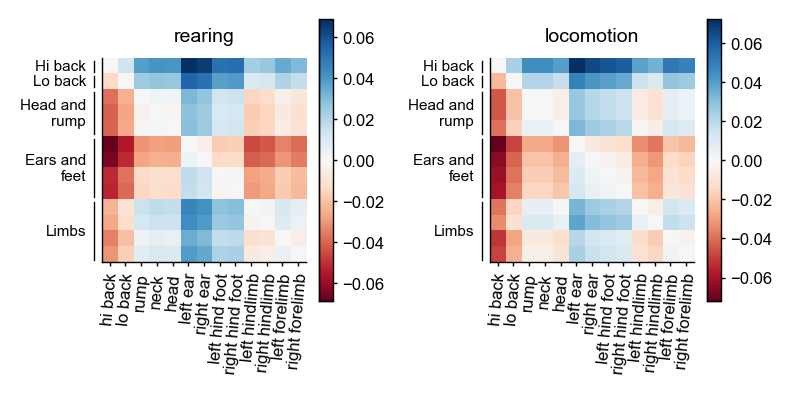

In [80]:
fig, ax = plt.subplots(1, 2, figsize = (4, 2))
for i, (n, coefs) in enumerate(zip(['rearing', 'locomotion'], [coefs_rear, coefs_loco])):
    vrng = abs(coefs).max()
    _ = ax[i].imshow(coefs, cmap = 'RdBu', vmin = -vrng, vmax = vrng)
    fig.colorbar(_, ax = ax[i])

    ax[i].set_xticks(np.arange(len(bone_order)))
    ax[i].set_xticklabels(bone_name_order, rotation = 85)
    ax[i].set_yticks([])
    ax[i].set_title(n)

    for bg, n in zip(bone_groups, bone_group_names):
        ax[i].add_artist(mpl.lines.Line2D(
            [-1, -1], [bg[0] - 0.35, bg[1] + 0.35],
            color = 'k', lw = 0.5, clip_on = False
        ))
        ax[i].add_artist(mpl.text.Text(
            -1.5, (bg[0] + bg[1]) / 2, n, ha = 'right', va = 'center',
            clip_on = False, fontsize = 5.5
        ))
plotter.finalize(fig, 'all-bl-corrs', transparent = True)

../../plots/notebook/panels/v4/f1.1_ikd-ja/all-bl-corrs-nobhv.pdf


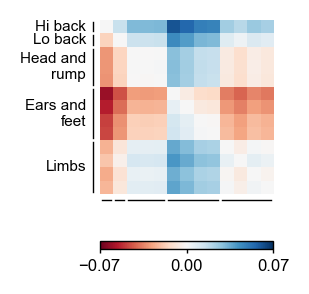

In [81]:
fig, ax = plt.subplots(1, 1, figsize = (1.5, 1.8))

vrng = viz.util._round_limits(-abs(coefs_totl).max(), abs(coefs_totl).max(), 1.)
_ = ax.imshow(coefs_totl, cmap = 'RdBu', vmin = vrng[0], vmax = vrng[1], aspect = 'equal')
cbar = fig.colorbar(_, ax = ax, orientation = 'horizontal')
cbar.ax.set_xticks([vrng[0], 0, vrng[1]])

for bg, n in zip(bone_groups, bone_group_names):
    ax.add_artist(mpl.lines.Line2D(
        [-1, -1], [bg[0] - 0.35, bg[1] + 0.35],
        color = 'k', lw = 0.5, clip_on = False
    ))
    ax.add_artist(mpl.lines.Line2D(
        [bg[0] - 0.35, bg[1] + 0.35], [len(bone_order), len(bone_order)],
        color = 'k', lw = 0.5, clip_on = False
    ))
    ax.add_artist(mpl.text.Text(
        -1.5, (bg[0] + bg[1]) / 2, n, ha = 'right', va = 'center',
        clip_on = False, fontsize = 5.5
    ))

ax.set_yticks([])
ax.set_xticks([])
viz.util.axes_off(ax)
plotter.finalize(fig, 'all-bl-corrs-nobhv', save = True, transparent = True, despine = False)

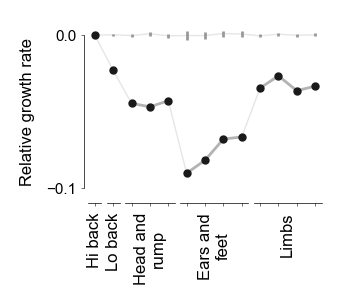

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.1_ikd-ja/relative-growth-rates.pdf')

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(1.7, 1.5))
ax.plot(coefs_totl, "-", color=".9", lw=0.5)
for bg in bone_groups:
    x = np.arange(bg[0], bg[1] + 1)
    ax.plot(x, coefs_totl[bg[0] : bg[1] + 1], "-", color=".7", lw=1)
    ax.plot(x, coefs_totl[bg[0] : bg[1] + 1], "o", color=colors.neutral, ms=2)

plt.plot(coefs_totl_shuf.mean(axis = 1), color = '.9', lw = 0.5, zorder = -2)
vu.grouped_stripplot(
    coefs_totl_shuf,
    ax=ax,
    colors=".6",
    jitter=0,
    points=False,
    error=lambda a, **kw: vu.ci(a, level=0.95, n=1000),
    errorbar_kw={"ms": 0, 'zorder': -2},
)



ax.set_xticks(np.arange(len(bone_order)))
ax.set_xticklabels(bone_name_order, rotation=70, horizontalalignment="right")
ax.set_yticks([-0.1, 0])
ax.set_ylim(-0.11, 0.01)
sns.despine(ax=ax, trim=True)
fig.tight_layout()

# Bone groups x axis
ax.set_xticks(np.arange(len(bone_order)))
ax.set_xticklabels([""] * len(bone_order))
sns.despine(ax=ax, trim=True, bottom=True)

ymin, _ = ax.get_ylim()
for bg, n in zip(bone_groups, bone_group_names):
    ax.add_artist(
        mpl.lines.Line2D(
            [bg[0] - 0.35, bg[1] + 0.35],
            [ymin, ymin],
            color="k",
            lw=0.25,
            clip_on=False,
        )
    )
    ax.add_artist(
        mpl.text.Text(
            (bg[0] + bg[1]) / 2,
            -0.05,
            n,
            ha="center",
            va="top",
            clip_on=False,
            fontsize=6,
            rotation=90,
            transform=mpl.transforms.blended_transform_factory(
                ax.transData, ax.transAxes
            ),
        )
    )
for x in range(0, len(bone_order)):
    ax.add_artist(
        mpl.lines.Line2D(
            [x, x],
            [-1e-2, -1e-2],
            color="k",
            lw=0.25,
            clip_on=False,
            solid_capstyle="butt",
        )
    )


ax.set_ylabel("Relative growth rate")

plotter.finalize(fig, "relative-growth-rates", despine=False)

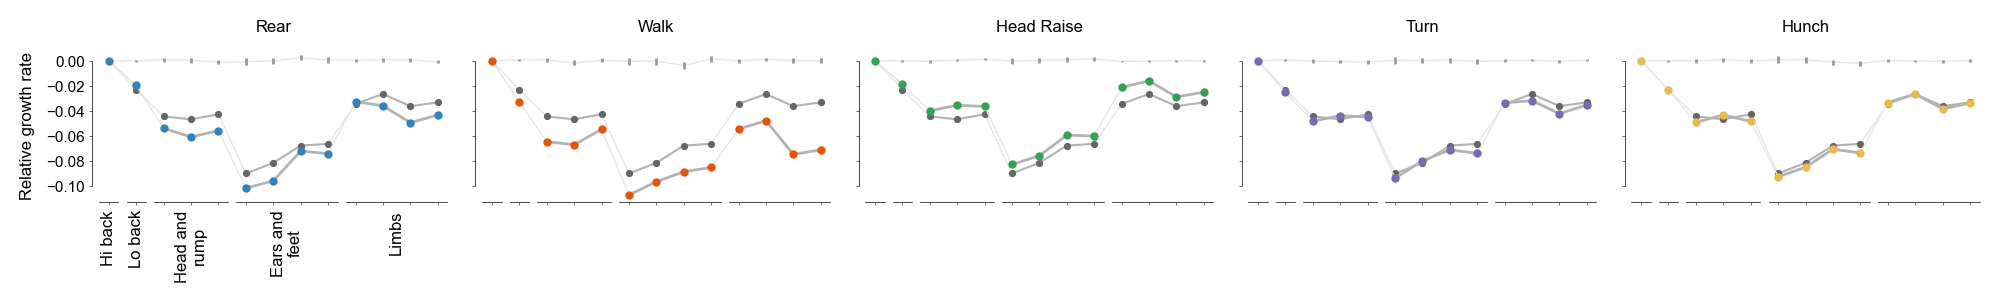

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.1_ikd-ja/relative-growth-rates-bhv.pdf')

In [239]:
fig, axes = plt.subplots(1, len(bhv_keys), figsize = (10, 1.5), sharey=True)
for i, (ax, bhv) in enumerate(zip(axes, bhv_keys)):
    
    ax.plot(coefs_totl, "-", color=".9", lw=0.5)
    for bg in bone_groups:
        x = np.arange(bg[0], bg[1] + 1)
        ax.plot(x, coefs_totl[bg[0] : bg[1] + 1], "-", color=".7", lw=0.75)
        ax.plot(x, coefs_totl[bg[0] : bg[1] + 1], "o", color='.4', ms=1.6)

    ax.plot(coefs_bhv[bhv], "-", color=".9", lw=0.5)
    for bg in bone_groups:
        x = np.arange(bg[0], bg[1] + 1)
        ax.plot(x, coefs_bhv[bhv][bg[0] : bg[1] + 1], '-', color = '.7', lw = 1)
        ax.plot(x, coefs_bhv[bhv][bg[0] : bg[1] + 1], 'o', color = bhv_pal[bhv], ms = 2)

    ax.plot(coefs_bhv_shuf[bhv].mean(axis = 1), color = '.9', lw = 0.5, zorder = -2)
    vu.grouped_stripplot(
        coefs_bhv_shuf[bhv],
        ax = ax,
        colors = ".6",
        jitter = 0,
        points = False,
        error = lambda a, **kw: vu.ci(a, level = 0.95, n = 1000),
        errorbar_kw = {'ms': 0, 'zorder': -2},
    )

    ax.set_xticks(np.arange(len(bone_order)))
    ax.set_xticklabels(bone_name_order, rotation = 70, horizontalalignment = 'right')
    sns.despine(ax = ax, trim = True)

    # Bone groups x axis
    ax.set_xticks(np.arange(len(bone_order)))
    ax.set_xticklabels([""] * len(bone_order))
    sns.despine(ax = ax, trim = True, bottom = True)
    ax.set_title(bhv_names[bhv].replace('\n', ' '))

for i, (ax, bhv) in enumerate(zip(axes, bhv_keys)):
    ymin, _ = ax.get_ylim()
    for bg, n in zip(bone_groups, bone_group_names):
        ax.add_artist(mpl.lines.Line2D(
            [bg[0] - 0.35, bg[1] + 0.35], [ymin, ymin],
            color = 'k', lw = 0.25, clip_on = False,
        ))
        if i == 0:
            ax.add_artist(mpl.text.Text(
                (bg[0] + bg[1]) / 2, -0.05, n, ha = 'center', va = 'top',
                clip_on = False, fontsize = 6, rotation = 90,
                transform = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes),
            ))
    for x in range(0, len(bone_order)):
        ax.add_artist(mpl.lines.Line2D(
            [x, x], [-1e-2, -1e-2],
            color = 'k', lw = 0.25, clip_on = False, solid_capstyle = 'butt',))
        

axes[0].set_ylabel("Relative growth rate")

plotter.finalize(fig, 'relative-growth-rates-bhv', despine = False)


### x. Example frame for joint angle

../../plots/notebook/panels/v4/f1.1_ikd-ja/ja-pose-example.pdf


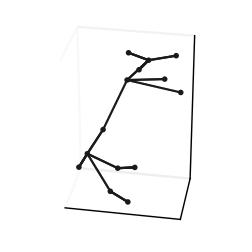

In [66]:
fig, ax = plt.subplots(1, 1, figsize = (1.3, 1.8), subplot_kw={"projection":'3d'})
arms = skeleton.default_armature
kws = dict(
    armature = arms,
    elev = 30, rot = -80,
    colors = [colors.neutral] * 14,
    line_colors = [colors.neutral] * 14,
    bone_n = 40,
    point_size = 4,
    line_size = 0.7,
    boundary = True
)


plot_mouse_3d(obs_keypts['52wk_m0'][800], ax, **kws)


plotter.finalize(fig, 'ja-pose-example', save = True, transparent = True, despine = False)

### 6. Nonuniform scaling; reduction of IKD variance

In [7]:
ntt_dist = lambda kpts: (
    la.norm(kpts[:, keypt_ix('nose'), :] - kpts[:, keypt_ix('t_base'), :], axis = -1)
)
scales = {s: ntt_dist(obs_keypts[s]).mean(axis = 0) for s in sessions}
ref_size = scales['3wk_m0']
scaled = {s: obs_keypts[s] / scales[s] * ref_size for s in sessions}


In [9]:
### save scales for later use
jl.dump(scales, '../../../data_explore/data/v4_f1.1-uniform-scales.p')

['../../../data_explore/data/v4_f1.1-uniform-scales.p']

In [68]:
ex_yng = '3wk_m0'
ex_old = '52wk_m0'
age_yng = '3'
age_old = '52'
frame_yng = 702
frame_old = la.norm(scaled[ex_yng][None, frame_yng] - scaled[ex_old], axis = -1).mean(axis = -1).argmin()


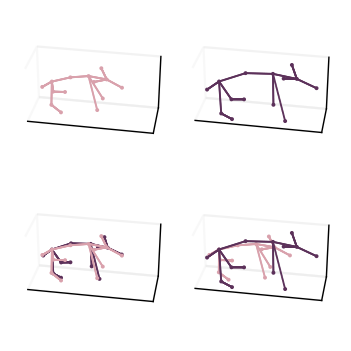

In [69]:

fig, ax = plt.subplots(2, 2, figsize = (1.8, 1.8), subplot_kw={"projection":'3d'})
arms = skeleton.default_armature
kws = lambda age: dict(
    armature = arms,
    elev = 30, rot = -80,
    colors = [colors.age_pal[age]] * 14,
    line_colors = [colors.age_pal[age]] * 14,
    bone_n = 40,
    point_size = 2,
    line_size = 0.5,
    boundary = True
)

for a in ax.ravel()[1:]:
    a.sharex(ax[0, 0])
    a.sharey(ax[0, 0])
    a.sharez(ax[0, 0])

plot_mouse_3d(obs_keypts[ex_yng][frame_yng], ax[0, 0], **kws(age_yng))
plot_mouse_3d(scaled[ex_yng][frame_yng], ax[1, 0], **kws(age_yng))
plot_mouse_3d(scaled[ex_old][frame_old], ax[1, 0], **kws(age_old))
plot_mouse_3d(obs_keypts[ex_yng][frame_yng], ax[1, 1], **kws(age_yng))
plot_mouse_3d(obs_keypts[ex_old][frame_old], ax[1, 1], **kws(age_old))
plot_mouse_3d(obs_keypts[ex_old][frame_old], ax[0, 1], **kws(age_old))



plotter.finalize(fig, 'uniform-scale-overlay', save = False, transparent = True, despine = False)

In [70]:
bls_scl = {s: la.norm(bone_locations(    scaled[s], skeleton.default_armature), axis = -1) for s in sessions}
bls_obs = {s: la.norm(bone_locations(obs_keypts[s], skeleton.default_armature), axis = -1) for s in sessions}
mean_fl = {s: (bls_scl[s][:, bone_names.index('left forelimb')] + bls_scl[s][:, bone_names.index('left forelimb')]) / 2 for s in sessions}
head = {s: bls_scl[s][:, bone_names.index('head')] for s in sessions}
lo_back = {s: bls_scl[s][:, bone_names.index('lo back')] for s in sessions}

mean_iqd = lambda x, mean_axis = (0,): scipy.stats.iqr([a.mean(axis = mean_axis) for a in x], axis = 0)
mean_iqd_scl = mean_iqd(bls_scl.values())
mean_iqd_obs = mean_iqd(bls_obs.values())

../../plots/notebook/panels/v4/f1.1_ikd-ja/uniform-scale-ikds.pdf


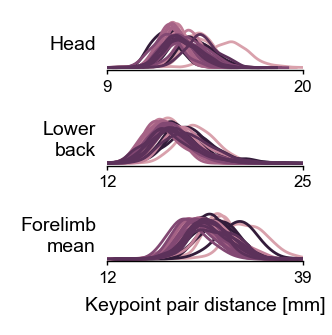

In [72]:
kw = dict(
    error = lambda a, **kw: viz.util.ci(a, level=0.95, n=1000),
    errorbar_kw = {'elinewidth': 0.5, 'ms': 2},
    jitter = 0.2,
    lighten_points = 0.5,
    lim_buffer = 1,
    colors = "k"
)

fig, ax = plt.subplots(3, 1, figsize = (1.7, 1.7))
for a, sl in age_groups.items():
    for s in sl:
        
        ax[0].plot(*viz.util.kde(head[s][::100], bw = 0.3, resolution = 300), lw = 1, color = colors.age_pal[a])
        ax[1].plot(*viz.util.kde(lo_back[s][::100], bw = 0.5, resolution = 300), lw = 1, color = colors.age_pal[a])
        ax[2].plot(*viz.util.kde(mean_fl[s][::100], bw = 1, resolution = 300), lw = 1, color = colors.age_pal[a])

viz.util.nticks(ax, 2)
for a in ax:
    a.set_yticks([])
    mean_lim = np.mean(a.get_xlim())
    limrng = np.ptp(a.get_xlim())
    viz.util.round_limits(a, precision = 0.8, y = False, vmin = mean_lim - 0.25 * limrng, vmax = mean_lim + 0.3 * limrng)
    sns.despine(ax = a, trim = True, left = True)

ax[0].set_ylabel('Head', rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
ax[1].set_ylabel('Lower\nback', rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
ax[2].set_ylabel('Forelimb\nmean', rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
ax[2].set_xlabel('Keypoint pair distance [mm]')

plotter.finalize(fig, "uniform-scale-ikds", save=True, despine=False, transparent = True)

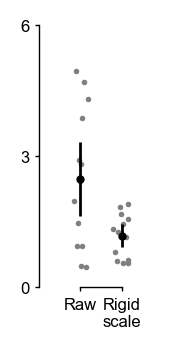

In [367]:
fig, ax = plt.subplots(1, 1, figsize = (0.8, 1.7))

kw = dict(
    error = lambda a, **kw: viz.util.ci(a, level=0.95, n=1000),
    # errorbar_kw = {'elinewidth': 0.5, 'ms': 2},
    jitter = 0.2,
    lighten_points = 0.5,
    lim_buffer = 1,
    colors = "k"
)
viz.util.grouped_stripplot(
    [mean_iqd_obs, mean_iqd_scl],
    ax = ax,
    xticks = ["Raw", "Rigid\nscale"],
    **kw
)

viz.util.nticks(ax, 3, x = False)
viz.util.round_limits(ax, x = False, precision=0.7, fixed_vmin = 0)
sns.despine(ax = ax, trim = True)

../../plots/notebook/panels/v4/f1.1_ikd-ja/mean-iqr-reduction.pdf


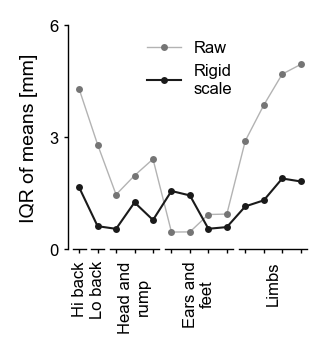

In [417]:
fig, ax = plt.subplots(1, 1, figsize = (1.7, 1.8))
ax.plot(mean_iqd_obs[bone_ix_order], '-o', markerfacecolor = viz.util.lighten(colors.neutral, 0.4), color = colors.semisubtle, lw = 0.5, ms = 2.5, label = "Raw")
ax.plot(mean_iqd_scl[bone_ix_order], '-o', color = colors.neutral, lw = 0.75, ms = 2.5, label = "Rigid\nscale")

viz.util.nticks(ax, 3, x = False)
viz.util.round_limits(ax, x = False, precision=0.5, fixed_vmin = 0)
ax.set_xticks(np.arange(len(bone_order)))
ax.set_xticklabels([""] * len(bone_order))
# ax.set_xticklabels(bone_name_order, rotation = 70, horizontalalignment = 'right')
sns.despine(ax = ax, trim = True, bottom = True)

for bg, n in zip(bone_groups, bone_group_names):
    ax.add_artist(mpl.lines.Line2D(
        [bg[0] - 0.35, bg[1] + 0.35], [0, 0],
        color = 'k', lw = 0.5, clip_on = False,
    ))
    ax.add_artist(mpl.text.Text(
        (bg[0] + bg[1]) / 2, -0.3, n, ha = 'center', va = 'top',
        clip_on = False, fontsize = 6, rotation = 90,
        # transform = mpl.transforms.blended_transform_factory(ax.transData, fig.transFigure),
    ))
for x in range(0, len(bone_order)):
    ax.add_artist(mpl.lines.Line2D(
        [x, x], [-1e-2, -1e-2],
        color = 'k', lw = 0.25, clip_on = False, solid_capstyle = 'butt',))
ax.set_ylabel("IQR of means [mm]")

viz.util.legend(ax, loc = 'upper center', bbox_to_anchor = None)

fig.tight_layout()

plotter.finalize(fig, 'mean-iqr-reduction', save = True, transparent = True, despine = False)
